In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv('../../results/resultados_weak_supervision.csv')

In [3]:
df_label = pd.read_csv('../../data/y_train_fakes.csv')

In [4]:
df.label.value_counts()

label
YES\n        2817
ABSTAIN\n     982
NO\n          650
Name: count, dtype: int64

In [5]:
df['label'] = df['label'].str.rstrip('\n')

In [6]:
df_pivot = df.pivot(index = 'artigo', columns='sinal_credibilidade',values='label')

In [7]:
color_map = {'YES': 1, 'NO': -1, 'ABSTAIN': 0}
numeric_df = df_pivot.replace(color_map)

C:\Users\rafae\AppData\Local\Temp\ipykernel_9248\2413569000.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  numeric_df = df_pivot.replace(color_map)


In [8]:
cmap = sns.color_palette(['red', 'white', 'green'], as_cmap=True)

In [9]:
numeric_df = numeric_df.reset_index()

In [10]:
numeric_df.drop(columns=['artigo'], inplace=True)

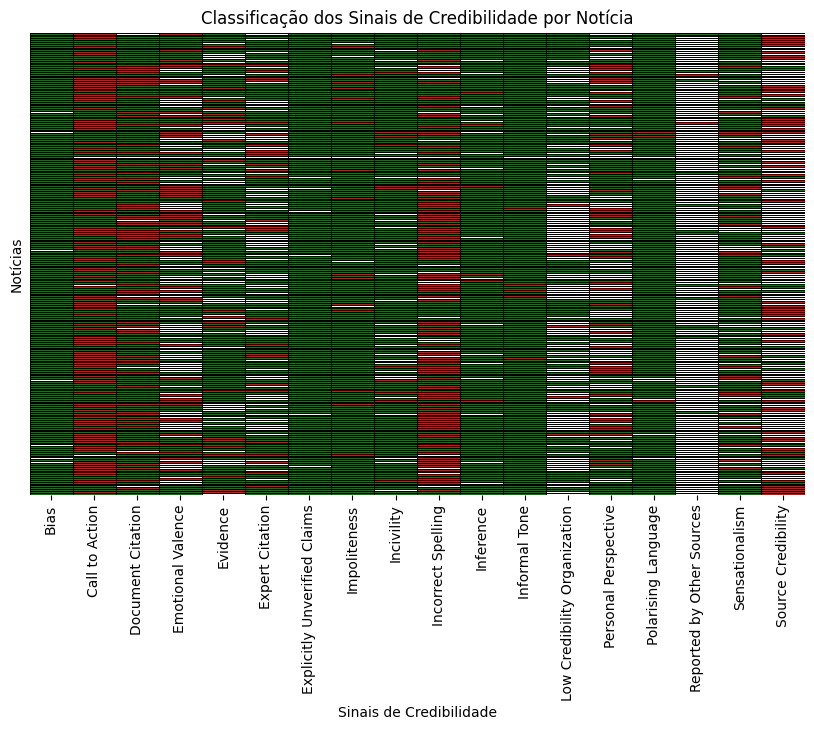

In [68]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    numeric_df[:300],
    cmap=cmap,
    cbar=False,
    linewidths=0.5,
    linecolor='black',
    xticklabels=True,
    yticklabels=False,
)
plt.xlabel('Sinais de Credibilidade')
plt.ylabel('Notícias')
plt.title('Classificação dos Sinais de Credibilidade por Notícia')


plt.show()

# Montando um Modelo

In [13]:
df_model = pd.concat([numeric_df, df_label], axis=1)

In [14]:
df_model.dropna(inplace=True)

In [15]:
X = df_model.drop(columns=['label'])  # Features
y = df_model['label']                

## Regressão Logística

In [16]:
model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

In [17]:
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.coef_[0]
})

In [18]:
importance.sort_values('Importance', ascending=False)

,Feature,Importance
8,Incivility,0.602505
14,Polarising Language,0.496516
12,Low Credibility Organization,0.350030
13,Personal Perspective,0.329650
0,Bias,0.269795
11,Informal Tone,0.227449
7,Impoliteness,0.210596
1,Call to Action,0.066928
5,Expert Citation,-0.047707
6,Explicitly Unverified Claims,-0.057417


In [19]:
probas = model.predict_proba(X)
preds = model.predict(X)

In [20]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.62      0.63      0.62       127
           1       0.60      0.58      0.59       120

    accuracy                           0.61       247
   macro avg       0.61      0.61      0.61       247
weighted avg       0.61      0.61      0.61       247



## XGBoost

In [37]:
# model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', objective='multi:softprob')
# model.fit(X, y)

In [38]:
# y_pred = model.predict(X)
# print(classification_report(y, y_pred))